In [12]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import matplotlib.pyplot as plt

import time

In [2]:
nba_data = pd.read_csv('../../data/final_driver.csv')

In [3]:
predictors = [e for e in nba_data.columns.tolist() if e not in ('accountsid', 'tickets_purchased')]
x = nba_data[predictors]
y = nba_data['tickets_purchased'] > 0
y = y.astype(int)

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state=512)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state=1024)

In [30]:
def format_params(params):
    params['num_leaves'] = max(int(round(params['num_leaves'])), 1)
    params['max_depth'] = max(int(round(params['max_depth'])), 1)
    params['min_gain_to_split'] = max(params['min_gain_to_split'], 0)
    params['min_child_weight'] = max(params['min_child_weight'], 0)
    params['subsample'] = max(min(params['subsample'], 1), 0)
    params['colsample_bytree'] = max(min(params['colsample_bytree'], 1), 0)
    return params

def lgb_evaluate(num_leaves,
                 max_depth,
                 min_gain_to_split,
                 min_child_weight,
                 subsample,
                 colsample_bytree):
    Dataset = lgb.Dataset(x, label=y)
        
    params = {}
    params['learning_rate'] = 0.01
    params['objective'] = 'binary'
    params['min_data_in_leaf'] = 100
    params['num_leaves'] = num_leaves
    params['max_depth'] = max_depth
    params['min_gain_to_split'] = min_gain_to_split
    params['min_child_weight'] = min_child_weight
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
    params = format_params(params)

    cv_result = lgb.cv(params, Dataset, num_boost_round=10000, nfold=5, 
                       metrics='auc', early_stopping_rounds=25)
    return -cv_result['auc-mean'][-1]
    
def plot_pdp(bst, X, col):
    # modified from
    #   https://github.com/dmlc/xgboost/issues/1514#issuecomment-245766250
    X_temp = X.copy()
    x_scan = np.linspace(
        np.percentile(X_temp.loc[:, col], 0.1),
        np.percentile(X_temp.loc[:, col], 99.5), 10)
    y_partial = []
    for point in x_scan:
        X_temp[col] = point
        y_partial.append(np.average(bst.predict(X_temp)))
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)
    
    ax.plot(x_scan, y_partial, '-', color = 'black', linewidth = 1)

    ax.set_xlim(min(x_scan), max(x_scan))
    ax.set_xlabel('Feature ' + col, fontsize = 10)    
    ax.set_ylabel('Partial Dependence', fontsize = 12)
    plt.show()
    return x_scan, y_partial

In [6]:
gbm = lgb.LGBMClassifier(n_estimators=10000)
gbm.fit(x_train, y_train, 
        eval_set=[(x_train, y_train), (x_test,y_test)], 
        eval_metric='auc', 
        early_stopping_rounds=25, 
        verbose=True)

[1]	training's auc: 0.882895	valid_1's auc: 0.887149
Training until validation scores don't improve for 25 rounds.
[2]	training's auc: 0.88292	valid_1's auc: 0.887165
[3]	training's auc: 0.888831	valid_1's auc: 0.891959
[4]	training's auc: 0.888935	valid_1's auc: 0.892108
[5]	training's auc: 0.891583	valid_1's auc: 0.895667
[6]	training's auc: 0.891627	valid_1's auc: 0.895711
[7]	training's auc: 0.891643	valid_1's auc: 0.895717
[8]	training's auc: 0.894963	valid_1's auc: 0.899037
[9]	training's auc: 0.895042	valid_1's auc: 0.899104
[10]	training's auc: 0.89509	valid_1's auc: 0.899123
[11]	training's auc: 0.895156	valid_1's auc: 0.899193
[12]	training's auc: 0.895226	valid_1's auc: 0.899251
[13]	training's auc: 0.895249	valid_1's auc: 0.899256
[14]	training's auc: 0.895255	valid_1's auc: 0.899263
[15]	training's auc: 0.895301	valid_1's auc: 0.899305
[16]	training's auc: 0.900353	valid_1's auc: 0.903647
[17]	training's auc: 0.900439	valid_1's auc: 0.903727
[18]	training's auc: 0.900643	v

[153]	training's auc: 0.91551	valid_1's auc: 0.913706
[154]	training's auc: 0.915534	valid_1's auc: 0.913716
[155]	training's auc: 0.915555	valid_1's auc: 0.913716
[156]	training's auc: 0.915575	valid_1's auc: 0.91373
[157]	training's auc: 0.91561	valid_1's auc: 0.91371
[158]	training's auc: 0.915623	valid_1's auc: 0.91371
[159]	training's auc: 0.915661	valid_1's auc: 0.913716
[160]	training's auc: 0.915753	valid_1's auc: 0.913716
[161]	training's auc: 0.915784	valid_1's auc: 0.913705
[162]	training's auc: 0.915816	valid_1's auc: 0.913722
[163]	training's auc: 0.91583	valid_1's auc: 0.91372
[164]	training's auc: 0.915849	valid_1's auc: 0.913727
[165]	training's auc: 0.91588	valid_1's auc: 0.913753
[166]	training's auc: 0.915921	valid_1's auc: 0.913765
[167]	training's auc: 0.915974	valid_1's auc: 0.913755
[168]	training's auc: 0.916024	valid_1's auc: 0.913762
[169]	training's auc: 0.916032	valid_1's auc: 0.91376
[170]	training's auc: 0.916068	valid_1's auc: 0.913774
[171]	training's au

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10000,
        nthread=-1, num_leaves=31, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [7]:
print("Validation AUROC: %.6f " % metrics.roc_auc_score(y_val, gbm.predict_proba(x_val)[:,1]))

Validation AUROC: 0.908255 


In [8]:
print("Validation accuracy: %.6f " % np.mean(y_val == gbm.predict(x_val)))

Validation accuracy: 0.980688 


In [9]:
feature_importance = dict(zip(x_train.columns.tolist(),gbm.booster_.feature_importance(importance_type='gain')))
for w in sorted(feature_importance, key=feature_importance.get, reverse=True):
    print(w, feature_importance[w])

premier_tickets 78652.0171934
value_tickets 39424.6143933
select_tickets 28594.6329685
marquee_tickets 24151.5188979
supersaver_tickets 16641.1328316
all_activity_10 13476.7099352
elite_tickets 4309.90123127
all_activity_11 4146.9508187
all_activity_24 3834.88605504
other_tickets 3644.69109412
ninetyd_activity_8 3322.86908277
preseason_tickets 3223.62423294
thirtyd_activity_24 1968.63446206
all_activity_12 1628.35363688
ninetyd_activity_24 1484.95711819
thirtyd_activity_10 1125.87344577
ninetyd_activity_27 1009.51666067
ninetyd_activity_10 996.56453766
all_activity_8 950.09011548
all_activity_27 846.709530643
ninetyd_activity_11 609.508054356
ninetyd_activity_32 547.024830049
all_activity_2 484.196531201
all_activity_1 468.721509104
all_activity_32 460.598753548
ninetyd_activity_12 373.549768145
thirtyd_activity_32 373.071251536
all_activity_6 370.04056567
ninetyd_activity_2 330.267056463
thirtyd_activity_11 324.855791086
thirtyd_activity_1 286.364529125
value_tickets_90d 273.848745446

In [10]:
imp_feat_idx = np.argsort(gbm.booster_.feature_importance(importance_type='gain'))[::-1]

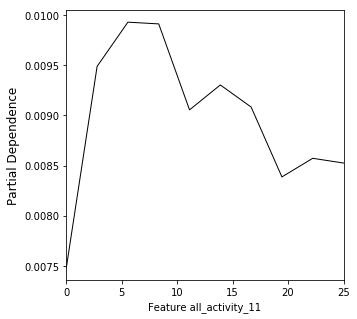

49.00728702545166


In [31]:
start = time.time()
x_scan, y_partial = plot_pdp(gbm, x_train, 'all_activity_11')
print(time.time() - start)

In [34]:
x_scan.tolist()

[0.0,
 2.7777777777777777,
 5.555555555555555,
 8.333333333333332,
 11.11111111111111,
 13.88888888888889,
 16.666666666666664,
 19.444444444444443,
 22.22222222222222,
 25.0]

In [33]:
y_partial

[0.0074820026229466948,
 0.0094885253944641361,
 0.0099288281969914741,
 0.0099115305868921859,
 0.0090545126319729018,
 0.0093029692133990427,
 0.0090828178121353745,
 0.0083861958781367638,
 0.0085717520592018571,
 0.0085245767589310698]

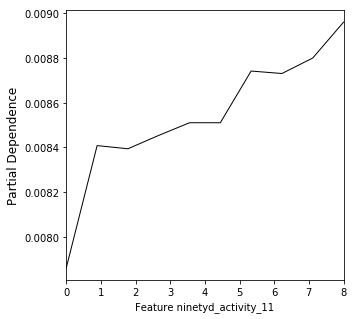

In [35]:
x_scan, y_partial = plot_pdp(gbm, x_train, 'ninetyd_activity_11')

In [36]:
x_scan.tolist()

[0.0,
 0.8888888888888888,
 1.7777777777777777,
 2.6666666666666665,
 3.5555555555555554,
 4.444444444444445,
 5.333333333333333,
 6.222222222222221,
 7.111111111111111,
 8.0]

In [37]:
y_partial

[0.0078625500451310372,
 0.0084082110182631311,
 0.0083940584281818956,
 0.0084538138085248904,
 0.0085104241688498342,
 0.0085104241688498342,
 0.0087415831401766869,
 0.0087305755701135041,
 0.0087997660105106571,
 0.0089601620314313304]

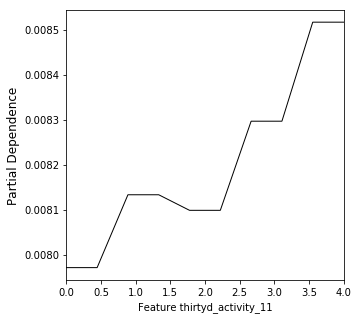

In [38]:
x_scan, y_partial = plot_pdp(gbm, x_train, 'thirtyd_activity_11')

In [39]:
x_scan.tolist()

[0.0,
 0.4444444444444444,
 0.8888888888888888,
 1.3333333333333333,
 1.7777777777777777,
 2.2222222222222223,
 2.6666666666666665,
 3.1111111111111107,
 3.5555555555555554,
 4.0]

In [40]:
y_partial

[0.0079710532357538458,
 0.0079710532357538458,
 0.0081330217666835455,
 0.0081330217666835455,
 0.008098426546484969,
 0.008098426546484969,
 0.0082965628076222698,
 0.0082965628076222698,
 0.0085167142088859397,
 0.0085167142088859397]

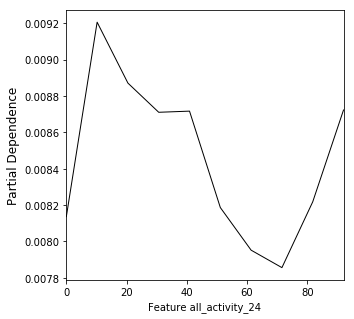

In [18]:
plot_pdp(gbm, x_train, 'all_activity_24')

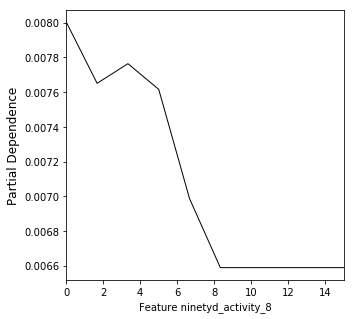

In [19]:
plot_pdp(gbm, x_train, 'ninetyd_activity_8')

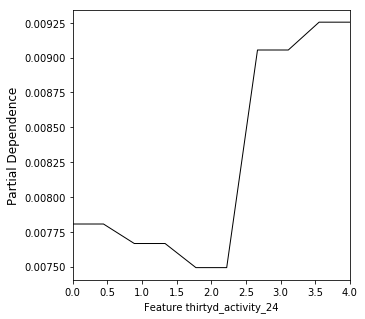

In [20]:
plot_pdp(gbm, x_train, 'thirtyd_activity_24')

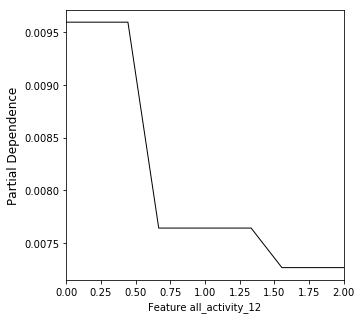

In [21]:
plot_pdp(gbm, x_train, 'all_activity_12')

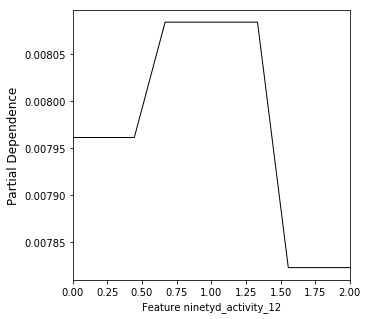

In [22]:
plot_pdp(gbm, x_train, 'ninetyd_activity_12')

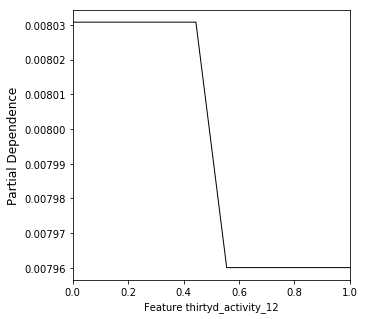

In [23]:
plot_pdp(gbm, x_train, 'thirtyd_activity_12')

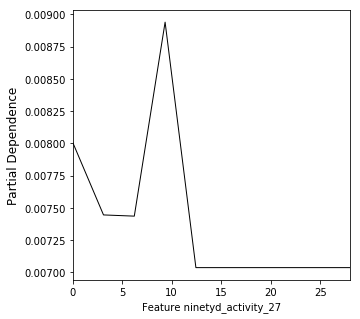

In [24]:
plot_pdp(gbm, x_train, 'ninetyd_activity_27')